# Freddie Mac Single Family Loan Classification

Build an LightGBM model To predict whether a loan will be a bad one using the data collected when the loan is(was) originated. (Comparing to XGBoost, LightGBM may treat categrocal features better.)

Data available from Freddie Mac ([Single Family Loan-Level Dataset](http://www.freddiemac.com/research/datasets/sf_loanlevel_dataset.page)). Loan with a term of 30 years originated between 1999 and 2003 are selected, so we are looking back from about 15 years away, and only completed/terminated loans are used. 
Good loans have been fully paid-off, while a bad one was terminated by other reasons.

This project is inspired by [Matthew C. F. Tso](https://towardsdatascience.com/predicting-bad-housing-loans-using-public-freddie-mac-data-a-tutorial-on-working-with-imbalanced-d2852c003996) (the Notebook is mainly based on his, with modifications here and there), through which I got
* hands on experience on LightGBM, and imblearn
* better understanding and hands on experience on imbalanced dataset, under/over sampling
* **a good starting point for further data modelling on Family Loan modelling**


Restart from [here](#restart) to avoid downloading data again. 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")
#warnings.simplefilter(action='ignore', category=FutureWarning)

from zipfile import ZipFile

import pandas as pd

import numpy as np 
from scipy import stats

import random

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

### Get the Data

* Original dataset download from Freddie Mac's [Single Family Loan-Level Dataset](http://www.freddiemac.com/research/datasets/sf_loanlevel_dataset.page)
* Will replace the specific values with NaN according to the user guide
* Save dataset to csv locally for convinience in the future

In [2]:
# copied from the README

header_orig = \
"""CREDIT SCORE
FIRST PAYMENT DATE
FIRST TIME HOMEBUYER FLAG
MATURITY DATE
METROPOLITAN STATISTICAL AREA
MORTGAGE INSURANCE PERCENTAGE
NUMBER OF UNITS
OCCUPANCY STATUS
ORIGINAL COMBINED LOAN-TO-VALUE
ORIGINAL DEBT-TO-INCOME RATIO
ORIGINAL UPB
ORIGINAL LOAN-TO-VALUE
ORIGINAL INTEREST RATE
CHANNEL
PREPAYMENT PENALTY MORTGAGE FLAG
PRODUCT TYPE
PROPERTY STATE
PROPERTY TYPE
POSTAL CODE
LOAN SEQUENCE NUMBER
LOAN PURPOSE
ORIGINAL LOAN TERM
NUMBER OF BORROWERS
SELLER NAME
SERVICER NAME
SUPER CONFORMING FLAG
Pre-HARP LOAN SEQUENCE NUMBER """

header_svcg = \
"""LOAN SEQUENCE NUMBER
MONTHLY REPORTING PERIOD
CURRENT ACTUAL UPB
CURRENT LOAN DELINQUENCY STATUS
LOAN AGE
REMAINING MONTHS TO LEGAL MATURITY
REPURCHASE FLAG
MODIFICATION FLAG
ZERO BALANCE CODE
ZERO BALANCE EFFECTIVE DATE
CURRENT INTEREST RATE
CURRENT DEFERRED UPB
DUE DATE OF LAST PAID INSTALLMENT
MI RECOVERIES
NET SALES PROCEEDS
NON MI RECOVERIES
EXPENSES
LEGAL COSTS
MAINTENANCE AND PRESERVATION COSTS
TAXES AND INSURANCE
MISCELLANEOUS EXPENSES
ACTUAL LOSS CALCULATION
MIDIFICATION COST
STEP MODIFICATION FLAG
DEFERRED PAYMENT MODIFICATION
ESTIMATED LOAN TO VALUE
ZERO BALANCE REMOVAL UPB
DELINQUENT ACCRUED INTEREST"""

header_orig = [s.strip().title().replace(' ', '').replace('-','') for s in header_orig.split('\n')]
header_svcg = [s.strip().title().replace(' ', '').replace('-','') for s in header_svcg.split('\n')]

In [3]:
print(header_orig)
print(header_svcg)

['CreditScore', 'FirstPaymentDate', 'FirstTimeHomebuyerFlag', 'MaturityDate', 'MetropolitanStatisticalArea', 'MortgageInsurancePercentage', 'NumberOfUnits', 'OccupancyStatus', 'OriginalCombinedLoanToValue', 'OriginalDebtToIncomeRatio', 'OriginalUpb', 'OriginalLoanToValue', 'OriginalInterestRate', 'Channel', 'PrepaymentPenaltyMortgageFlag', 'ProductType', 'PropertyState', 'PropertyType', 'PostalCode', 'LoanSequenceNumber', 'LoanPurpose', 'OriginalLoanTerm', 'NumberOfBorrowers', 'SellerName', 'ServicerName', 'SuperConformingFlag', 'PreHarpLoanSequenceNumber']
['LoanSequenceNumber', 'MonthlyReportingPeriod', 'CurrentActualUpb', 'CurrentLoanDelinquencyStatus', 'LoanAge', 'RemainingMonthsToLegalMaturity', 'RepurchaseFlag', 'ModificationFlag', 'ZeroBalanceCode', 'ZeroBalanceEffectiveDate', 'CurrentInterestRate', 'CurrentDeferredUpb', 'DueDateOfLastPaidInstallment', 'MiRecoveries', 'NetSalesProceeds', 'NonMiRecoveries', 'Expenses', 'LegalCosts', 'MaintenanceAndPreservationCosts', 'TaxesAndIns

In [4]:
dfs_orig = []
dfs_svcg = []

# only select LoanSequenceNumber and ZeroBalanceCode
svcg_cols = [0, 8]
svcg_col_names = [header_svcg[i] for i in svcg_cols]

for Y in range(1999,2004):
    for q in range(1,5):
        print(f'Y{Y}-Q{q}', end=',..')
        
        FileName = f'../data/1999-2003/historical_data1_Q{q}{Y}.zip'
        
        zip_file = ZipFile(FileName)
        for text_file in zip_file.infolist():
            if 'time' in text_file.filename:
                dfs_svcg.append(
                    pd.read_csv( zip_file.open(text_file.filename), sep='|', header=None, usecols=svcg_cols, names=svcg_col_names)
                )
            else:
                dfs_orig.append(
                    pd.read_csv( zip_file.open(text_file.filename), sep='|', header=None, names=header_orig )
                )

Y1999-Q1,..Y1999-Q2,..Y1999-Q3,..Y1999-Q4,..Y2000-Q1,..Y2000-Q2,..Y2000-Q3,..Y2000-Q4,..Y2001-Q1,..Y2001-Q2,..Y2001-Q3,..Y2001-Q4,..Y2002-Q1,..Y2002-Q2,..Y2002-Q3,..Y2002-Q4,..Y2003-Q1,..Y2003-Q2,..Y2003-Q3,..Y2003-Q4,..

In [5]:
df_orig = pd.concat(dfs_orig)
df_svcg = pd.concat(dfs_svcg)

In [6]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7255384 entries, 0 to 299513
Data columns (total 27 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CreditScore                    int64  
 1   FirstPaymentDate               int64  
 2   FirstTimeHomebuyerFlag         object 
 3   MaturityDate                   int64  
 4   MetropolitanStatisticalArea    float64
 5   MortgageInsurancePercentage    int64  
 6   NumberOfUnits                  int64  
 7   OccupancyStatus                object 
 8   OriginalCombinedLoanToValue    int64  
 9   OriginalDebtToIncomeRatio      int64  
 10  OriginalUpb                    int64  
 11  OriginalLoanToValue            int64  
 12  OriginalInterestRate           float64
 13  Channel                        object 
 14  PrepaymentPenaltyMortgageFlag  object 
 15  ProductType                    object 
 16  PropertyState                  object 
 17  PropertyType                   object 
 18  Pos

In [7]:
# the last two cols seems empty (from the sample text file)
df_orig.iloc[:, 25].value_counts()
df_orig.iloc[:, 26].value_counts()

Series([], Name: SuperConformingFlag, dtype: int64)

Series([], Name: PreHarpLoanSequenceNumber, dtype: int64)

In [8]:
df_orig.drop(header_orig[25:], axis=1, inplace=True)

In [9]:
df_orig.PostalCode = df_orig.PostalCode.astype('Int64') # NaN properly
df_orig.MetropolitanStatisticalArea = df_orig.MetropolitanStatisticalArea.astype('Int64')

In [10]:
# set NaN values according to the README
df_orig.CreditScore[df_orig.CreditScore==9999] = np.NaN
df_orig.MortgageInsurancePercentage[df_orig.MortgageInsurancePercentage==999] = np.NaN
df_orig.NumberOfUnits[df_orig.NumberOfUnits==99] = np.NaN
df_orig.OccupancyStatus[df_orig.OccupancyStatus=='9'] = np.NaN
df_orig.OriginalCombinedLoanToValue[df_orig.OriginalCombinedLoanToValue==999] = np.NaN
df_orig.OriginalDebtToIncomeRatio[df_orig.OriginalDebtToIncomeRatio==999] = np.NaN
df_orig.OriginalLoanToValue[df_orig.OriginalLoanToValue==999] = np.NaN
df_orig.Channel[df_orig.Channel=='9'] = np.NaN
df_orig.PropertyType[df_orig.PropertyType=='99'] = np.NaN
df_orig.LoanPurpose[df_orig.LoanPurpose==9] = np.NaN
df_orig.NumberOfBorrowers[df_orig.NumberOfBorrowers==99] = np.NaN

In [3]:
# save files
#df_orig.to_csv('orig_99_03.csv.gz', index=False)
#df_svcg.to_csv('svcg_99_03.csv.gz', index=False)

In [4]:
# del dfs_orig
# del dfs_svcg
# del header_orig
# del header_svcg

### **Always Continue/Restart From Here**<a id='restart'></a>

In [2]:
pd.options.display.max_columns = None

df_orig = pd.read_csv('orig_99_03.csv.gz')
#df_svcg = pd.read_csv('svcg_99_03.csv.gz')

In [3]:
df_orig.isna().mean(axis=0) #.round(2)*100

CreditScore                      0.004819
FirstPaymentDate                 0.000000
FirstTimeHomebuyerFlag           0.000000
MaturityDate                     0.000000
MetropolitanStatisticalArea      0.143618
MortgageInsurancePercentage      0.031891
NumberOfUnits                    0.000004
OccupancyStatus                  0.000000
OriginalCombinedLoanToValue      0.000065
OriginalDebtToIncomeRatio        0.021925
OriginalUpb                      0.000000
OriginalLoanToValue              0.000054
OriginalInterestRate             0.000000
Channel                          0.000000
PrepaymentPenaltyMortgageFlag    0.006816
ProductType                      0.000000
PropertyState                    0.000000
PropertyType                     0.000136
PostalCode                       0.000206
LoanSequenceNumber               0.000000
LoanPurpose                      0.000000
OriginalLoanTerm                 0.000000
NumberOfBorrowers                0.000351
SellerName                       0

In [4]:
df_orig.MetropolitanStatisticalArea.value_counts(dropna=False) # NaN means: N/A or not a MSA
df_orig.PrepaymentPenaltyMortgageFlag.value_counts(dropna=False) # this should be an important feature: whether the borrower has paid a penalty

NaN        1042002
16974.0     248784
33460.0     192047
31084.0     160308
12060.0     160015
            ...   
13220.0          1
48060.0          1
26140.0          1
43420.0          1
16540.0          1
Name: MetropolitanStatisticalArea, Length: 426, dtype: int64

N      7191891
NaN      49454
Y        14039
Name: PrepaymentPenaltyMortgageFlag, dtype: int64

In [5]:
# drop NaNs, using OR should be fast
df_orig.dropna(subset=['CreditScore', 
                       'MortgageInsurancePercentage', 
                       'OriginalCombinedLoanToValue',
                       'OriginalDebtToIncomeRatio',
                       'OriginalLoanToValue',
                       'PropertyType',
                       'NumberOfBorrowers'
                      ], inplace=True)   # these features are either important or only contain small number of NaNs



In [6]:
# keep only the Loans with a term of 30 years, which is also the majority product

df_orig = df_orig[ (df_orig.MaturityDate//100 - df_orig.FirstPaymentDate//100) == 30 ]
df_orig.drop(['MaturityDate', 'OriginalLoanTerm'], axis=1, inplace=True)

In [7]:
df_orig.select_dtypes(exclude='number').head(2)

,FirstTimeHomebuyerFlag,OccupancyStatus,Channel,PrepaymentPenaltyMortgageFlag,ProductType,PropertyState,PropertyType,LoanSequenceNumber,LoanPurpose,SellerName,ServicerName
0,N,P,R,N,FRM,PA,SF,F199Q1000001,P,Other sellers,Other servicers
2,N,P,R,N,FRM,PA,SF,F199Q1000003,P,Other sellers,Other servicers


**Loan Purpose:**
* P = Purchase
* C = Refinance - Cash Out
* N = Refinance - No Cash Out
* R = Refinance - Not Specified
* 9 =Not Available (I have changed it to NaN)

In [8]:
for col in 'FirstTimeHomebuyerFlag PrepaymentPenaltyMortgageFlag'.split():
    df_orig[col] = df_orig[col].map({'N':0,'Y':1})
df_orig.select_dtypes(exclude='number').head(2)

,OccupancyStatus,Channel,ProductType,PropertyState,PropertyType,LoanSequenceNumber,LoanPurpose,SellerName,ServicerName
0,P,R,FRM,PA,SF,F199Q1000001,P,Other sellers,Other servicers
2,P,R,FRM,PA,SF,F199Q1000003,P,Other sellers,Other servicers


In [9]:
df_orig.ProductType.value_counts()
# all of them are FRM, Fixed Rate Mortgage; drop it.

FRM    6213310
Name: ProductType, dtype: int64

In [10]:
df_orig.drop('ProductType', axis=1, inplace=True)

In [11]:
df_orig.LoanSequenceNumber.unique().shape

(6213310,)

In [12]:
df_orig.set_index('LoanSequenceNumber', inplace=True)

In [13]:
df_orig.head(2)

,CreditScore,FirstPaymentDate,FirstTimeHomebuyerFlag,MetropolitanStatisticalArea,MortgageInsurancePercentage,NumberOfUnits,OccupancyStatus,OriginalCombinedLoanToValue,OriginalDebtToIncomeRatio,OriginalUpb,OriginalLoanToValue,OriginalInterestRate,Channel,PrepaymentPenaltyMortgageFlag,PropertyState,PropertyType,PostalCode,LoanPurpose,NumberOfBorrowers,SellerName,ServicerName
LoanSequenceNumber,,,,,,,,,,,,,,,,,,,,,
F199Q1000001,751.0,199910,0.0,NaN,0.0,1.0,P,71.0,20.0,180000,71.0,6.3,R,0.0,PA,SF,19300.0,P,2.0,Other sellers,Other servicers
F199Q1000003,755.0,199905,0.0,29540.0,30.0,1.0,P,95.0,38.0,138000,95.0,6.6,R,0.0,PA,SF,17500.0,P,2.0,Other sellers,Other servicers


In [14]:
int_cols = """
 0   CreditScore                    int64  
 1   FirstPaymentDate               int64  
 2   FirstTimeHomebuyerFlag         object 
 4   MetropolitanStatisticalArea    float64
 5   MortgageInsurancePercentage    int64  
 6   NumberOfUnits                  int64  
 8   OriginalCombinedLoanToValue    int64  
 9   OriginalDebtToIncomeRatio      int64  
 10  OriginalUpb                    int64  
 11  OriginalLoanToValue            int64  
 14  PrepaymentPenaltyMortgageFlag  object 
 18  PostalCode                     float64
 22  NumberOfBorrowers              int64
"""

int_cols = [s.split()[1] for s in int_cols.split('\n') if s]

for col in int_cols:
    df_orig[col] = df_orig[col].astype('Int64')
    
df_orig.head(3)

,CreditScore,FirstPaymentDate,FirstTimeHomebuyerFlag,MetropolitanStatisticalArea,MortgageInsurancePercentage,NumberOfUnits,OccupancyStatus,OriginalCombinedLoanToValue,OriginalDebtToIncomeRatio,OriginalUpb,OriginalLoanToValue,OriginalInterestRate,Channel,PrepaymentPenaltyMortgageFlag,PropertyState,PropertyType,PostalCode,LoanPurpose,NumberOfBorrowers,SellerName,ServicerName
LoanSequenceNumber,,,,,,,,,,,,,,,,,,,,,
F199Q1000001,751,199910,0,<NA>,0,1,P,71,20,180000,71,6.3,R,0,PA,SF,19300,P,2,Other sellers,Other servicers
F199Q1000003,755,199905,0,29540,30,1,P,95,38,138000,95,6.6,R,0,PA,SF,17500,P,2,Other sellers,Other servicers
F199Q1000005,732,199904,0,17140,0,1,P,25,10,53000,25,6.5,R,0,OH,SF,45200,N,1,Other sellers,Other servicers


In [15]:
cat_cols = df_orig.select_dtypes(exclude='number').columns.to_list()
cat_cols += 'MetropolitanStatisticalArea PostalCode'.split()  # numeric form

In [16]:
# use pandas.cat to convert categorical features to int, which deals with <NA> more conveniently than sklearn labelencoder 
for col in cat_cols:
    df_orig[col] = df_orig[col].astype('category')
    df_orig[f'{col}_cat'] = df_orig[col].cat.codes

In [17]:
df_orig.head(2)

,CreditScore,FirstPaymentDate,FirstTimeHomebuyerFlag,MetropolitanStatisticalArea,MortgageInsurancePercentage,NumberOfUnits,OccupancyStatus,OriginalCombinedLoanToValue,OriginalDebtToIncomeRatio,OriginalUpb,OriginalLoanToValue,OriginalInterestRate,Channel,PrepaymentPenaltyMortgageFlag,PropertyState,PropertyType,PostalCode,LoanPurpose,NumberOfBorrowers,SellerName,ServicerName,OccupancyStatus_cat,Channel_cat,PropertyState_cat,PropertyType_cat,LoanPurpose_cat,SellerName_cat,ServicerName_cat,MetropolitanStatisticalArea_cat,PostalCode_cat
LoanSequenceNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F199Q1000001,751,199910,0,NaN,0,1,P,71,20,180000,71,6.3,R,0,PA,SF,19300,P,2,Other sellers,Other servicers,1,2,39,4,2,31,22,-1,178
F199Q1000003,755,199905,0,29540,30,1,P,95,38,138000,95,6.6,R,0,PA,SF,17500,P,2,Other sellers,Other servicers,1,2,39,4,2,31,22,211,160


In [18]:
# df_svcg
df_svcg = pd.read_csv('svcg_99_03.csv.gz')

df_svcg.dropna(inplace=True) 
df_svcg.ZeroBalanceCode = df_svcg.ZeroBalanceCode.astype('int')
df_svcg.ZeroBalanceCode.value_counts()

1     6864735
9       99721
2       19842
6       17226
3       12763
15      11159
Name: ZeroBalanceCode, dtype: int64

From README:

|Reason for Loan Termination | Zero Balance Code | Priority |
|---|---|---|
|Prepaid or Matured (Voluntary Payoff) | 01 | 6 | 
|Third Party Sale |02 | 4 |
|Short Sale or Charge Off | 03 | 5 |
|Repurchase prior to Property Disposition | 06 | 2 | 
|REO Disposition | 09 | 3 |
|NPL/RPL Loan Sale | 15 | 1 |

In [19]:
df_svcg['IsBadLoan'] = (df_svcg.ZeroBalanceCode!=1).astype('Int64')
df_svcg.set_index('LoanSequenceNumber', inplace=True)
df_svcg.head(2)

,ZeroBalanceCode,IsBadLoan
LoanSequenceNumber,,
F199Q1000001,1,0
F199Q1000002,1,0


In [20]:
data = df_svcg[['IsBadLoan']].join(df_orig, how='inner') # inner join
#data[data.columns[~data.columns.isin(cat_cols)]]
#data.columns[data.columns.str.contains('cat')]
data.head(3)
data.shape

,IsBadLoan,CreditScore,FirstPaymentDate,FirstTimeHomebuyerFlag,MetropolitanStatisticalArea,MortgageInsurancePercentage,NumberOfUnits,OccupancyStatus,OriginalCombinedLoanToValue,OriginalDebtToIncomeRatio,OriginalUpb,OriginalLoanToValue,OriginalInterestRate,Channel,PrepaymentPenaltyMortgageFlag,PropertyState,PropertyType,PostalCode,LoanPurpose,NumberOfBorrowers,SellerName,ServicerName,OccupancyStatus_cat,Channel_cat,PropertyState_cat,PropertyType_cat,LoanPurpose_cat,SellerName_cat,ServicerName_cat,MetropolitanStatisticalArea_cat,PostalCode_cat
LoanSequenceNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F199Q1000001,0,751,199910,0,NaN,0,1,P,71,20,180000,71,6.3,R,0,PA,SF,19300,P,2,Other sellers,Other servicers,1,2,39,4,2,31,22,-1,178
F199Q1000003,0,755,199905,0,29540,30,1,P,95,38,138000,95,6.6,R,0,PA,SF,17500,P,2,Other sellers,Other servicers,1,2,39,4,2,31,22,211,160
F199Q1000005,0,732,199904,0,17140,0,1,P,25,10,53000,25,6.5,R,0,OH,SF,45200,N,1,Other sellers,Other servicers,1,2,36,4,1,31,22,78,427


(6009673, 31)

In [21]:
data.IsBadLoan.value_counts(dropna=False)

0      5869379
1       140294
NaN          0
Name: IsBadLoan, dtype: Int64

In [22]:
data[data.columns[~data.columns.isin(cat_cols)]].isna().mean().to_frame().T

,IsBadLoan,CreditScore,FirstPaymentDate,FirstTimeHomebuyerFlag,MortgageInsurancePercentage,NumberOfUnits,OriginalCombinedLoanToValue,OriginalDebtToIncomeRatio,OriginalUpb,OriginalLoanToValue,OriginalInterestRate,PrepaymentPenaltyMortgageFlag,NumberOfBorrowers,OccupancyStatus_cat,Channel_cat,PropertyState_cat,PropertyType_cat,LoanPurpose_cat,SellerName_cat,ServicerName_cat,MetropolitanStatisticalArea_cat,PostalCode_cat
0,0.0,0.0,0.0,0.245947,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.006104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
data_filled = data.copy()
#data_filled.FirstTimeHomebuyerFlag = data_filled.FirstTimeHomebuyerFlag.astype('Int64')
#data_filled.PrepaymentPenaltyMortgageFlag = data_filled.PrepaymentPenaltyMortgageFlag.astype('Int64')

# fill with random choice for FirstTImeHomebuyerFlag
fill = data_filled.FirstTimeHomebuyerFlag.value_counts()
mask = data_filled.FirstTimeHomebuyerFlag.isna()
data_filled.FirstTimeHomebuyerFlag[mask] = random.choices(fill.index.to_list(), fill.to_list(), k=mask.sum())

# these two should be okay according to the README, and the number is small anyway
data_filled.PrepaymentPenaltyMortgageFlag = data_filled.PrepaymentPenaltyMortgageFlag.fillna(0)
data_filled.NumberOfUnits.fillna(data_filled.NumberOfUnits.mode()[0], inplace=True)

In [ ]:
for col in 'FirstTimeHomebuyerFlag NumberOfUnits PrepaymentPenaltyMortgageFlag NumberOfBorrowers IsBadLoan'.split():
    data_filled[col] = data_filled[col].astype('int8')

for col in 'CreditScore MortgageInsurancePercentage OriginalCombinedLoanToValue OriginalDebtToIncomeRatio OriginalUpb OriginalLoanToValue OriginalInterestRate'.split(): 
    data_filled[col] = data_filled[col].astype('float32')

In [24]:
data_filled[data.columns[~data.columns.isin(cat_cols)]].isna().sum().to_frame().T
# should be all zero now

,IsBadLoan,CreditScore,FirstPaymentDate,FirstTimeHomebuyerFlag,MortgageInsurancePercentage,NumberOfUnits,OriginalCombinedLoanToValue,OriginalDebtToIncomeRatio,OriginalUpb,OriginalLoanToValue,OriginalInterestRate,PrepaymentPenaltyMortgageFlag,NumberOfBorrowers,OccupancyStatus_cat,Channel_cat,PropertyState_cat,PropertyType_cat,LoanPurpose_cat,SellerName_cat,ServicerName_cat,MetropolitanStatisticalArea_cat,PostalCode_cat
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**I will mainly use the filled data, but also will test the unfilled data with LightGBM:**
* dropna will remove about 25% data
* FirstTimeHomebuyersFlag may be an important feature, although with the missing data
* LGBM is able to deal with missing values (should be better than simple imputation)

In [25]:
# make a copy, in case I want to a fresh restart
data_copy = data.copy()
dat_filled_copy = data_filled.copy()

del df_orig
del df_svcg

# Exploratory Data Analysis

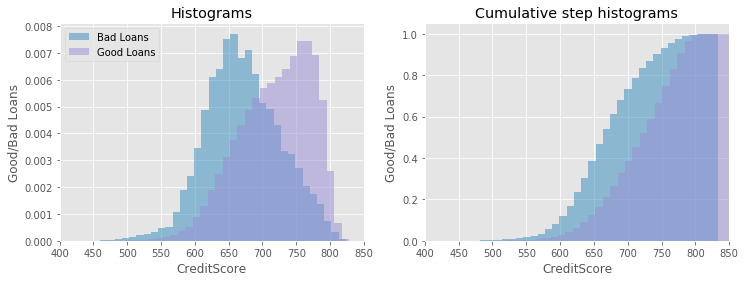

In [26]:
good_loans = data_filled[data_filled['IsBadLoan']==0]
bad_loans  = data_filled[data_filled['IsBadLoan']==1]

# for continuous variables
col = 'CreditScore'
nbins = 50

fig, ax = plt.subplots(1,2,figsize=(12, 4))
_ = ax[0].hist( bad_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=False, label= 'Bad Loans', alpha = 0.5, color='C1')
_ = ax[0].hist(good_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=False, label='Good Loans', alpha = 0.5, color='C2')

_ = ax[1].hist( bad_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=True, label= 'Bad Loans', alpha = 0.5, color='C1')
_ = ax[1].hist(good_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=True, label='Good Loans', alpha = 0.5, color='C2')

ax[0].set_xlim(400, 850)
ax[0].set_xlabel(col)
ax[0].set_ylabel('Good/Bad Loans')
ax[0].legend(loc='upper left')
ax[0].set_title('Histograms')

ax[1].set_xlim(400, 850)
ax[1].set_xlabel(col)
ax[1].set_ylabel('Good/Bad Loans')
# ax[1].legend(loc='upper left')
ax[1].set_title('Cumulative step histograms')

plt.show();

# apparently important 

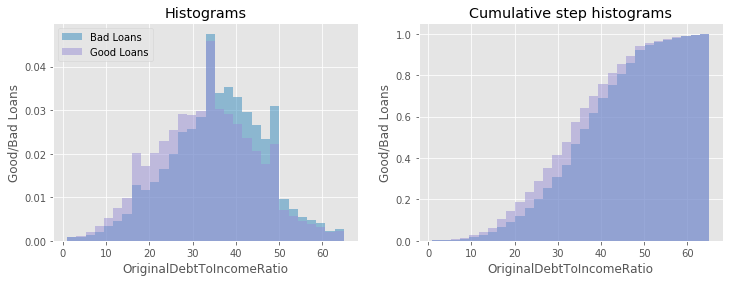

In [27]:
col = 'OriginalDebtToIncomeRatio'
nbins = 30

fig, ax = plt.subplots(1,2,figsize=(12, 4))
_ = ax[0].hist( bad_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=False, label= 'Bad Loans', alpha = 0.5, color='C1')
_ = ax[0].hist(good_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=False, label='Good Loans', alpha = 0.5, color='C2')

_ = ax[1].hist( bad_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=True, label= 'Bad Loans', alpha = 0.5, color='C1')
_ = ax[1].hist(good_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=True, label='Good Loans', alpha = 0.5, color='C2')

# ax[0].set_xlim(400, 850)
ax[0].set_xlabel(col)
ax[0].set_ylabel('Good/Bad Loans')
ax[0].legend(loc='upper left')
ax[0].set_title('Histograms')

# ax[1].set_xlim(400, 850)
ax[1].set_xlabel(col)
ax[1].set_ylabel('Good/Bad Loans')
# ax[1].legend(loc='upper left')
ax[1].set_title('Cumulative step histograms')

plt.show();

# less important

In [28]:
# categoral variables

# Split and transform for scikit-learn models
Spliting data into features and outcome; perform transformation for scikit-learn models

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

def split_n_transform(df, features, target, pipeline=None, fit=True):
    """
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),  # missing values: disregarded in fit, and maintained in transform
    ])
    """
    
    X = df[features]
    if pipeline:
        if fit: 
            X = pipeline.fit_transform(X)
        else:
            X = pipeline.transform(X)
    y = df[target].to_numpy(int)
    
    if fit:
        return X, y, pipeline
    else:
        return X, y

### Feature Selection
* features: all
* features_no_cs: No credit score
* features_no_geo: no location-related features
* features_no_geo_seller: no location-related features, nor seller informations


In [30]:
target = 'IsBadLoan'
features = data_filled.columns.drop(cat_cols+[target, 'FirstPaymentDate'])  # all features but firstpaymentdate

features_no_cs = data.columns.drop(cat_cols+[target, 'FirstPaymentDate', 'CreditScore'])

geo_cols = 'PropertyState_cat MetropolitanStatisticalArea_cat  PostalCode_cat'.split()
seller_cols = 'SellerName_cat ServicerName_cat'.split()

features_no_geo = data.columns.drop(cat_cols+[target, 'FirstPaymentDate'] + geo_cols)
features_no_geo_seller = data.columns.drop(cat_cols+[target, 'FirstPaymentDate'] + geo_cols+seller_cols)

In [83]:
# use all features
train = data_filled[data_filled.FirstPaymentDate<200300]
test  = data_filled[data_filled.FirstPaymentDate>200300]

pipeline = Pipeline([
        #('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler())
    ])

X_train, y_train, preprocessor = split_n_transform( train, features, target, pipeline)
X_test,  y_test  = split_n_transform( test, features, target, preprocessor, False)

# typo here, has to rerun all cells related (X_test, y_test)
# rerun done

In [32]:
np.sum(y_train==1)/len(y_train), np.sum(y_test==1)/len(y_test)

(0.021454014364157507, 0.021454014364157507)

# Balanced Classification Strategy

## Under-sampling

In [33]:
def under_sample_df(df, target, target_val=1):
    shuffle = df.sample(frac=1, random_state=4) # Not needed, but is ok to keep
    
    shuffle_bad = shuffle.loc[shuffle[target] == target_val]
    shuffle_good_subsample = shuffle.loc[shuffle[target] != target_val].sample(n=len(shuffle_bad),random_state=42)
    
    combined = pd.concat([shuffle_good_subsample, shuffle_bad])
    
    return combined.sample(frac=1,random_state=4)

### **Comment**

I think Tso's way of resampling could be improved.

Here, the train set and test set are resampled, respectively. (Much better than resample the whole data set and then split the resampled data into train and test.) However:
* the test set should not be resampled, becaue that is the *unseen* data
* the resampled train set was further splitted into train and val sets, but I think the val set should be treated as similar as to the unseen test set.

I still follow his way in this notebook, but will prepare another notebook focusing on LightGBM with the following scheme:
1. split the data set into train, val and test, or into train and test
2. only resample the train set
3. fit the model with the train set, tunning parameters with the help of the val set, and test the model with the un-resampled test set

In the end of this Notebook, I will train the models with the resampled train (or resampled train+val), and test with the untouched test set. 

In [34]:
train_under = under_sample_df(train, target)
test_under = under_sample_df(test, target)

# It is not necessary to scale the data for LGDB, but it should not hurt either, and is necessary for many other methods
pipeline = Pipeline([
        #('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler())
    ])
X_train_under, y_train_under, preprocessor_under = split_n_transform( train_under, features, target, pipeline)

X_test_under,  y_test_under  = split_n_transform( test_under, features, target, preprocessor_under, False)

## Over-sampling

In [35]:
from imblearn.over_sampling import SMOTE, SMOTENC # SMOTENC for catigorical variables

def over_sample_df(df_inp, features, target, cat_cols=None):
    # Resample the minority class. You can change the strategy to 'auto' if you are not sure.

    df = df_inp[features].copy()
    
    if cat_cols is None:
        sm = SMOTE(sampling_strategy='minority', random_state=7, n_jobs=16)
    else:
        for col in features:
            if col in cat_cols: 
                continue
            df[col] = df[col].astype(float) # int variables not accepted for smote
        sm = SMOTENC(features.isin(cat_cols), sampling_strategy='minority', random_state=7, n_jobs=16)
    
    # Fit the model to generate the data.
    over_X, over_y= sm.fit_sample(df, df_inp[target].to_numpy(int))
    
    oversampled = pd.concat([pd.DataFrame(over_X, columns=features), pd.DataFrame(over_y, columns=[target])], axis=1)

    return oversampled.sample(frac=1,random_state=4)

In [36]:
# cat_features are the features will be treated as categrical ones (and integeral ones)
cat_features =   ['FirstTimeHomebuyerFlag', 'PrepaymentPenaltyMortgageFlag'] \
                +['OccupancyStatus_cat', 'Channel_cat', 'PropertyState_cat', 
                  'PropertyType_cat', 'LoanPurpose_cat', 'SellerName_cat', 
                  'ServicerName_cat', 'MetropolitanStatisticalArea_cat', 'PostalCode_cat'] \
                +['NumberOfUnits', 'NumberOfBorrowers']

train_over = over_sample_df(train, features, target, cat_features)
test_over = over_sample_df(test, features, target, cat_features)

pipeline = Pipeline([
        #('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler())
    ])
X_train_over, y_train_over, preprocessor_over = split_n_transform( train_over, features, target, pipeline)
X_test_over,  y_test_over  = split_n_transform( test_over, features, target, preprocessor_over, False)

In [37]:
# takes a long time to resample, save a copy
train_over.to_csv('train_over_sampled.csv.gz', index=False)
test_over.to_csv('test_over_sampled.csv.gz', index=False)

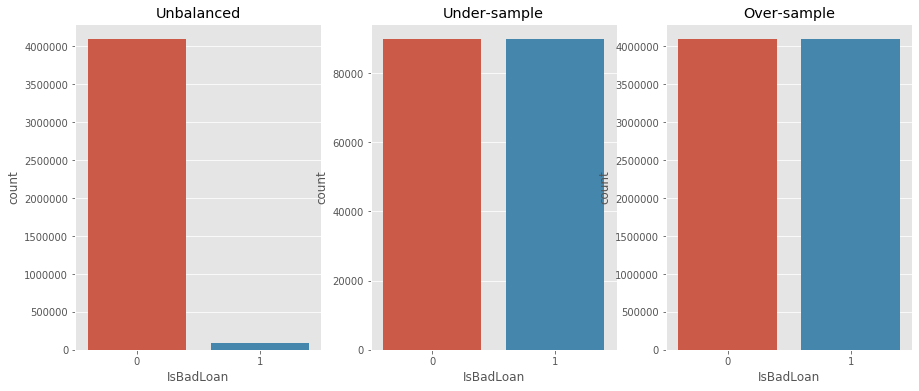

In [38]:
# show the effects of resampling

fig, ax = plt.subplots(1,3,figsize=(15, 6))

sns.countplot('IsBadLoan', data=train, ax=ax[0])
ax[0].title.set_text('Unbalanced')

sns.countplot('IsBadLoan', data=train_under, ax=ax[1])
ax[1].title.set_text('Under-sample')

sns.countplot('IsBadLoan', data=train_over, ax=ax[2])
ax[2].title.set_text('Over-sample')

plt.show();

## Correlation Plots

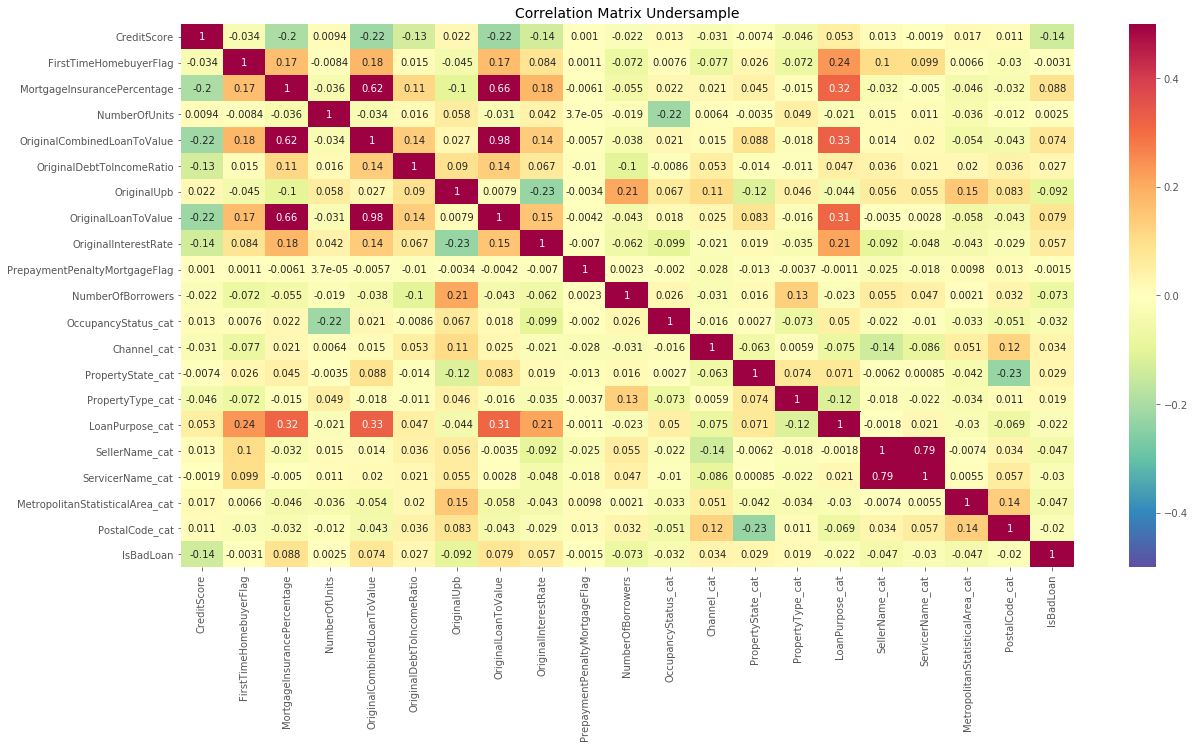

In [39]:
# un-resampled

fig, ax = plt.subplots(figsize=(20,10))         
corr = train[features.to_list()+[target]].corr()
sns.heatmap(corr, cmap='Spectral_r', annot_kws={'size':10}, ax=ax, vmin = -0.5, vmax = 0.5, annot = True)
ax.set_title("Correlation Matrix Undersample", fontsize=14)
plt.show();

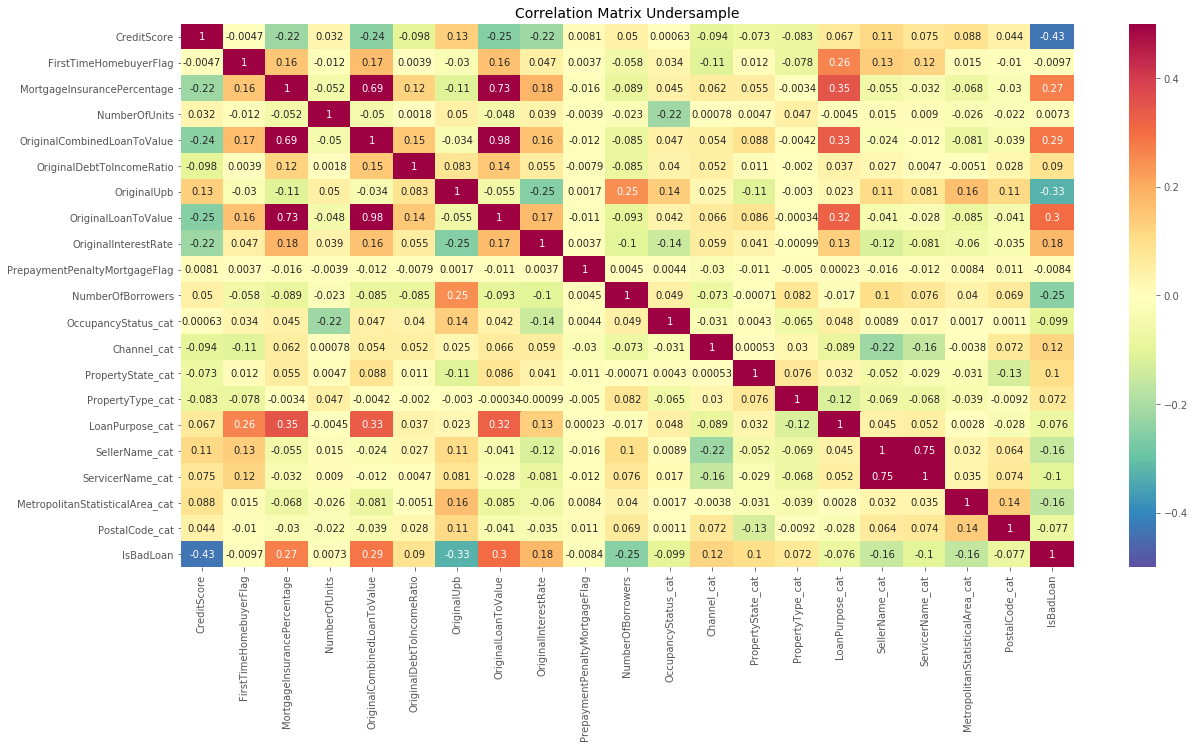

In [40]:
# under sampled
fig, ax = plt.subplots(figsize=(20,10))         
corr_under = train_under[features.to_list()+[target]].corr()
sns.heatmap(corr_under, cmap='Spectral_r', annot_kws={'size':10}, ax=ax, vmin = -0.5, vmax = 0.5, annot = True)
ax.set_title("Correlation Matrix Undersample", fontsize=14)
plt.show();

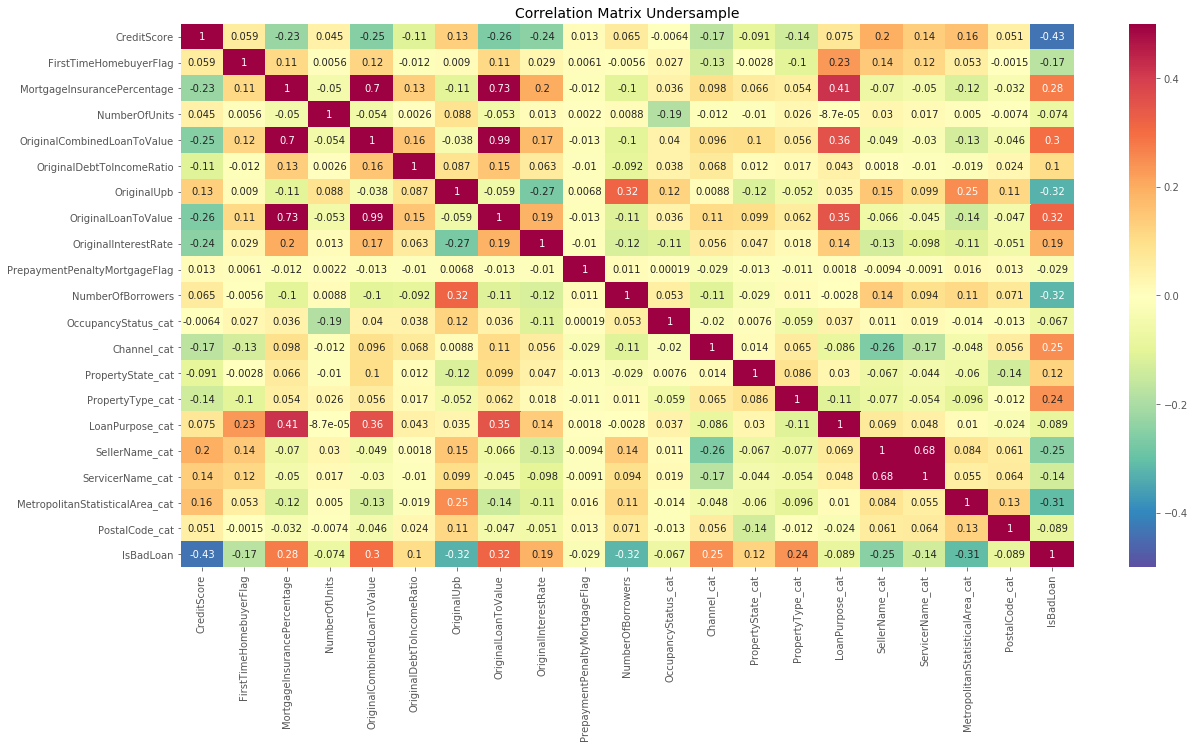

In [41]:
#over sampled
fig, ax = plt.subplots(figsize=(20,10))         
corr_over = train_over.corr()
sns.heatmap(corr_over, cmap='Spectral_r', annot_kws={'size':10}, ax=ax, vmin = -0.5, vmax = 0.5, annot = True)
ax.set_title("Correlation Matrix Undersample", fontsize=14)
plt.show();

In [42]:
pd.concat([corr.IsBadLoan, corr_under.IsBadLoan, corr_over.IsBadLoan], axis=1).T.set_index(pd.Index(['Unbalanced', 'UnderSampled', 'OverSampled']))

# the difference is quite big

,CreditScore,FirstTimeHomebuyerFlag,MortgageInsurancePercentage,NumberOfUnits,OriginalCombinedLoanToValue,OriginalDebtToIncomeRatio,OriginalUpb,OriginalLoanToValue,OriginalInterestRate,PrepaymentPenaltyMortgageFlag,NumberOfBorrowers,OccupancyStatus_cat,Channel_cat,PropertyState_cat,PropertyType_cat,LoanPurpose_cat,SellerName_cat,ServicerName_cat,MetropolitanStatisticalArea_cat,PostalCode_cat,IsBadLoan
Unbalanced,-0.137198,-0.003083,0.087567,0.002499,0.074239,0.026985,-0.091608,0.079253,0.056625,-0.001459,-0.073487,-0.032381,0.034223,0.029075,0.019003,-0.021779,-0.047088,-0.029852,-0.046528,-0.019812,1.0
UnderSampled,-0.430523,-0.009741,0.273145,0.007277,0.288293,0.089807,-0.326239,0.304444,0.176115,-0.008426,-0.246144,-0.099188,0.117908,0.101458,0.071707,-0.076335,-0.156052,-0.104006,-0.160789,-0.077223,1.0
OverSampled,-0.434757,-0.173220,0.276759,-0.073533,0.299375,0.101678,-0.324665,0.317907,0.189259,-0.028918,-0.319840,-0.067210,0.247119,0.124338,0.239468,-0.089208,-0.246371,-0.136312,-0.306555,-0.088572,1.0


In [97]:
# I will simply reuse these functions, but use pred_proba so the AUCs are correctly defined

def plot_roc_curve(fpr, tpr, thres, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.show();
    
from sklearn.metrics import *

# bad function, will rewrite
def prediction_summary_balanced(clf_name,session_name, y, pred, threshold=0.5):
    if np.unique(pred).shape[0]==2:
        print("--- {0:<30} {1:<20} ---".format(clf_name, session_name),
          '\n Accuracy:',accuracy_score(y, pred>threshold), 'ROC AUC:',roc_auc_score(y, pred), 'PRC AUC:', average_precision_score(y,pred), 
          '\n F1 Score:',f1_score(y, pred),'Matthews CC:',matthews_corrcoef(y,pred),
          '\n Precision Recall fscore support:',precision_recall_fscore_support(y,pred),
          '\n',confusion_matrix(y, pred))
    else:
        print("--- {0:<30} {1:<20} ---".format(clf_name, session_name),
          '\n Accuracy:',accuracy_score(y, pred>threshold), 'ROC AUC:',roc_auc_score(y, pred), 'PRC AUC:', average_precision_score(y,pred), 
          '\n F1 Score:',f1_score(y, pred>threshold),'Matthews CC:',matthews_corrcoef(y,pred>threshold),
          '\n Precision Recall fscore support:',precision_recall_fscore_support(y,pred>threshold),
          '\n',confusion_matrix(y, pred>threshold))
    
def prediction_summary_imbalanced(clf_name,session_name,y, pred, threshold=0.5):
    if np.unique(pred).shape[0]==2:
        print("--- {0:<30} {1:<20} Balanced ---".format(clf_name, session_name),
          '\n Accuracy:',accuracy_score(y, pred>threshold), 'ROC AUC:',roc_auc_score(y, pred), 'PRC AUC:', average_precision_score(y,pred), 
          '\n F1 Score:',f1_score(y, pred),'Matthews CC:',matthews_corrcoef(y,pred),
          '\n Precision Recall fscore support:',precision_recall_fscore_support(y,pred),
          '\n',confusion_matrix(y, pred))
    else:
        print("--- {0:<30} {1:<20} Balanced ---".format(clf_name, session_name),
          '\n Accuracy:',accuracy_score(y, pred>threshold), 'ROC AUC:',roc_auc_score(y, pred), 'PRC AUC:', average_precision_score(y,pred), 
          '\n F1 Score:',f1_score(y, pred>threshold),'Matthews CC:',matthews_corrcoef(y,pred>threshold),
          '\n Precision Recall fscore support:',precision_recall_fscore_support(y,pred>threshold),
          '\n',confusion_matrix(y, pred>threshold))

## Result

In [61]:
# I will simply reuse these functions, replace predict with predict_proba for correctly calculate the ROC-AUC and PRC-AUC
# default parameters, but usually not too bad

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import time

def classification_balanced(train_X, train_y, test_X,test_y):
    gbrt_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)   # use 100, the new default value
    sgd_clf = SGDClassifier(random_state = 42, loss="modified_huber")     # to support predict_proba
    rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)        # use 100, the new default value
    ada_clf = AdaBoostClassifier(random_state = 42)
    
    voting_clf = VotingClassifier(
    estimators=[('sgd', sgd_clf), ('rf', rnd_clf),('gb',gbrt_clf),('ada',ada_clf)],
    voting='hard')
    voting_clf.fit(train_X, train_y)
    
    y_pred_train_all = pd.DataFrame(data = pd.Series(train_y))
    y_pred_test_all= pd.DataFrame(data = pd.Series(test_y))

    for clf in (sgd_clf,rnd_clf,gbrt_clf,ada_clf, voting_clf):
        start_time = time.time()
        clf.fit(train_X, train_y)
        try:
            y_pred_train = clf.predict_proba(train_X)[:,1] # clf.predict(train_X)  predict_proba(train_X)[:,1]
            y_pred_test = clf.predict_proba(test_X)[:,1] # clf.predict(test_X)
        except:
            y_pred_train = clf.predict(train_X)
            y_pred_test =  clf.predict(test_X)
            
        y_pred_train_all[clf.__class__.__name__] = pd.Series(y_pred_train).values
        y_pred_test_all[clf.__class__.__name__] = pd.Series(y_pred_test).values
                   
        prediction_summary_balanced(clf.__class__.__name__,'Training', train_y,y_pred_train)
        prediction_summary_balanced(clf.__class__.__name__,'Testing',test_y, y_pred_test)    
        print("--- %s seconds ---" % (time.time() - start_time))    

In [98]:
# reuse the function, adding the parameter of cat_features, modified some default parameters, use predicted probability directly

import lightgbm as lgb

cat_features_lgb =['FirstTimeHomebuyerFlag', 'PrepaymentPenaltyMortgageFlag'] \
                 +['OccupancyStatus_cat', 'Channel_cat', 'PropertyState_cat', 
                   'PropertyType_cat', 'LoanPurpose_cat', 'SellerName_cat', 
                   'ServicerName_cat', 'MetropolitanStatisticalArea_cat', 'PostalCode_cat']  \
                 +['NumberOfUnits', 'NumberOfBorrowers']

# the last two are reasonable, since they are usually 1 and 2
    
def call_lgb(train, test, features, target, cat_features, is_unbalanced_flag=False, valid_fraction = 0.15, lgb_params=None):

#     def pr_auc(y_pred, y_true):
#         return 'pr_auc', average_precision_score(y_true.get_label(), y_pred), True
    # feval=pr_auc
    # num_leaves: 2^max_depth*5/8     #[40, 80, 160]
    # boosting: 'gdbt', 'goss', 'rf'  #['gdbt', 'goss']
    
    start_time = time.time()
    
    nval = int(len(train) * valid_fraction)
    train = train[:-nval ]
    valid = train[-nval :]

    dtrain = lgb.Dataset(train[features], label=train[target])
    dvalid = lgb.Dataset(valid[features], label=valid[target])
    dtest  = lgb.Dataset( test[features], label= test[target])

    param = {'num_leaves': 63, 'objective': 'binary', 'learning_rate':0.1, 'is_unbalance': is_unbalanced_flag}
    if lgb_params: param.update(lgb_params)
    param['metric'] = 'auc' # default logloss
    num_round = 1000
    bst = lgb.train(param, dtrain, num_boost_round=num_round, valid_sets=[dvalid],
                    feature_name='auto', categorical_feature=cat_features, verbose_eval=100, early_stopping_rounds=20)

    ypred_lgb_train = bst.predict(train[features], num_iteration=bst.best_iteration)
    ypred_lgb_valid = bst.predict(valid[features], num_iteration=bst.best_iteration)
    ypred_lgb_test  = bst.predict( test[features], num_iteration=bst.best_iteration)   

    importance = pd.DataFrame(data = bst.feature_importance(), index = bst.feature_name(), columns = ['Importance'])
    print(importance.sort_values(by='Importance', ascending = False))
    
    if is_unbalanced_flag == True:
        prediction_summary_imbalanced('Light LGB',  'Training', train[target], ypred_lgb_train)
        prediction_summary_imbalanced('Light LGB','Valdiation', valid[target], ypred_lgb_valid)
        prediction_summary_imbalanced('Light LGB',   'Testing',  test[target],  ypred_lgb_test)
    else:
        prediction_summary_balanced('Light LGB',  'Training', train[target], ypred_lgb_train)
        prediction_summary_balanced('Light LGB','Valdiation', valid[target], ypred_lgb_valid)
        prediction_summary_balanced('Light LGB',   'Testing',  test[target], ypred_lgb_test)
    print("--- %s seconds ---" % (time.time() - start_time))     
    return bst

In [63]:
classification_balanced(X_train_under, y_train_under, X_test_under, y_test_under)

--- SGDClassifier                  Training             --- 
 Accuracy: 0.767681548381349 ROC AUC: 0.8452879996957658 PRC AUC: 0.8286747112795765 
 F1 Score: 0.7713520060062365 Matthews CC: 0.535639230817459 
 Precision Recall fscore support: (array([0.77656074, 0.75935477]), array([0.75162867, 0.78373442]), array([0.76389133, 0.77135201]), array([89797, 89797])) 
 [[67494 22303]
 [19420 70377]]
--- SGDClassifier                  Testing              --- 
 Accuracy: 0.6808127215478147 ROC AUC: 0.7728298774619752 PRC AUC: 0.7535466797599492 
 F1 Score: 0.6191578847880536 Matthews CC: 0.3822146405149949 
 Precision Recall fscore support: (array([0.63658803, 0.76738806]), array([0.84270353, 0.51892192]), array([0.72528634, 0.61915788]), array([50497, 50497])) 
 [[42554  7943]
 [24293 26204]]
--- 4.121610641479492 seconds ---
--- RandomForestClassifier         Training             --- 
 Accuracy: 0.9999888637705046 ROC AUC: 1.0 PRC AUC: 1.0 
 F1 Score: 0.9999888636464876 Matthews CC: 0.999

In [99]:
train_under_, test_under_ = train_under.copy(), test_under.copy()
for col in 'FirstTimeHomebuyerFlag NumberOfUnits PrepaymentPenaltyMortgageFlag NumberOfBorrowers IsBadLoan'.split():
    train_under_[col] = train_under_[col].astype('int8')
    test_under_[col] = test_under_[col].astype('int8')

for col in 'CreditScore MortgageInsurancePercentage OriginalCombinedLoanToValue OriginalDebtToIncomeRatio OriginalUpb OriginalLoanToValue'.split(): 
    train_under_[col] = train_under_[col].astype('float32')
    test_under_[col] = test_under_[col].astype('float32')
    
call_lgb(train_under_, test_under_, features, target, cat_features_lgb)

Training until validation scores don't improve for 20 rounds
[100]	valid_0's auc: 0.945983
[200]	valid_0's auc: 0.961892
[300]	valid_0's auc: 0.970535
[400]	valid_0's auc: 0.97668
[500]	valid_0's auc: 0.981738
[600]	valid_0's auc: 0.985498
[700]	valid_0's auc: 0.988361
[800]	valid_0's auc: 0.990722
[900]	valid_0's auc: 0.992663
[1000]	valid_0's auc: 0.994012
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.994012
                                 Importance
PostalCode_cat                        11403
CreditScore                            9207
OriginalUpb                            8775
OriginalDebtToIncomeRatio              6344
OriginalInterestRate                   5285
MetropolitanStatisticalArea_cat        3834
OriginalCombinedLoanToValue            3227
SellerName_cat                         2750
ServicerName_cat                       2485
OriginalLoanToValue                    1756
LoanPurpose_cat                        1481
PropertyState_cat               

In [100]:
call_lgb(train_under_, test_under_, features_no_geo_seller, target, [_ for _ in cat_features_lgb if _ in features_no_geo_seller])   

Training until validation scores don't improve for 20 rounds
[100]	valid_0's auc: 0.879029
[200]	valid_0's auc: 0.889201
[300]	valid_0's auc: 0.89745
[400]	valid_0's auc: 0.905265
[500]	valid_0's auc: 0.911606
[600]	valid_0's auc: 0.918115
[700]	valid_0's auc: 0.923629
[800]	valid_0's auc: 0.92837
[900]	valid_0's auc: 0.932999
[1000]	valid_0's auc: 0.938061
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.938061
                               Importance
CreditScore                         13323
OriginalUpb                         13151
OriginalDebtToIncomeRatio            9831
OriginalInterestRate                 8159
OriginalCombinedLoanToValue          5403
LoanPurpose_cat                      2600
OriginalLoanToValue                  2478
MortgageInsurancePercentage          1689
Channel_cat                          1632
NumberOfBorrowers                    1554
OccupancyStatus_cat                   807
FirstTimeHomebuyerFlag                628
PropertyType_ca

In [101]:
call_lgb(train_under_, test_under_, features_no_cs, target, [_ for _ in cat_features_lgb if _ in features_no_cs])   

Training until validation scores don't improve for 20 rounds
[100]	valid_0's auc: 0.930554
[200]	valid_0's auc: 0.946943
[300]	valid_0's auc: 0.957546
[400]	valid_0's auc: 0.965137
[500]	valid_0's auc: 0.970936
[600]	valid_0's auc: 0.975973
[700]	valid_0's auc: 0.979939
[800]	valid_0's auc: 0.983402
[900]	valid_0's auc: 0.986049
[1000]	valid_0's auc: 0.988479
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.988479
                                 Importance
PostalCode_cat                        11469
OriginalUpb                           11273
OriginalDebtToIncomeRatio              8217
OriginalInterestRate                   6885
OriginalCombinedLoanToValue            4250
MetropolitanStatisticalArea_cat        3924
SellerName_cat                         3008
ServicerName_cat                       2752
OriginalLoanToValue                    2107
LoanPurpose_cat                        1918
PropertyState_cat                      1429
MortgageInsurancePercentage    

In [67]:
classification_balanced(X_train_over, y_train_over, X_test_over, y_test_over)

--- SGDClassifier                  Training             --- 
 Accuracy: 0.8199404994433268 ROC AUC: 0.8990009582492431 PRC AUC: 0.8881798872394224 
 F1 Score: 0.8222037362793407 Matthews CC: 0.6400884688037931 
 Precision Recall fscore support: (array([0.82829858, 0.81199743]), array([0.80721112, 0.83266988]), array([0.8176189 , 0.82220374]), array([4095760, 4095760])) 
 [[3306143  789617]
 [ 685344 3410416]]
--- SGDClassifier                  Testing              --- 
 Accuracy: 0.7218994045508083 ROC AUC: 0.8223034058778818 PRC AUC: 0.8114594726347802 
 F1 Score: 0.6752585040261482 Matthews CC: 0.46332527072346896 
 Precision Recall fscore support: (array([0.6723826 , 0.81132826]), array([0.86552411, 0.5782747 ]), array([0.7568253, 0.6752585]), array([1773619, 1773619])) 
 [[1535110  238509]
 [ 747980 1025639]]
--- 118.45582699775696 seconds ---
--- RandomForestClassifier         Training             --- 
 Accuracy: 0.9999907221126237 ROC AUC: 0.9999990012220966 PRC AUC: 0.9999987888

In [102]:
train_over_, test_over_ = train_over.copy(), test_over.copy()
for col in 'FirstTimeHomebuyerFlag NumberOfUnits PrepaymentPenaltyMortgageFlag NumberOfBorrowers IsBadLoan'.split():
    train_over_[col] = train_over_[col].astype('int8')
    test_over_[col] = test_over_[col].astype('int8')                                                                                

call_lgb(train_over_, test_over_, features, target, cat_features_lgb)

Training until validation scores don't improve for 20 rounds
[100]	valid_0's auc: 0.997409
[200]	valid_0's auc: 0.9981
[300]	valid_0's auc: 0.99843
[400]	valid_0's auc: 0.99863
[500]	valid_0's auc: 0.998777
[600]	valid_0's auc: 0.998904
[700]	valid_0's auc: 0.99901
[800]	valid_0's auc: 0.999105
[900]	valid_0's auc: 0.999182
[1000]	valid_0's auc: 0.999244
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.999244
                                 Importance
PostalCode_cat                        21294
MetropolitanStatisticalArea_cat        6841
OriginalDebtToIncomeRatio              5169
OriginalUpb                            4930
CreditScore                            4826
OriginalInterestRate                   4568
SellerName_cat                         2878
OriginalCombinedLoanToValue            2126
ServicerName_cat                       1939
OriginalLoanToValue                    1706
PropertyState_cat                      1604
MortgageInsurancePercentage         

In [103]:
call_lgb(train_over_, test_over_, features_no_geo_seller, target, [_ for _ in cat_features_lgb if _ in features_no_geo_seller])   

Training until validation scores don't improve for 20 rounds
[100]	valid_0's auc: 0.995689
[200]	valid_0's auc: 0.996333
[300]	valid_0's auc: 0.996578
[400]	valid_0's auc: 0.996756
[500]	valid_0's auc: 0.996897
[600]	valid_0's auc: 0.997023
[700]	valid_0's auc: 0.997146
[800]	valid_0's auc: 0.997246
[900]	valid_0's auc: 0.997358
[1000]	valid_0's auc: 0.997436
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.997436
                               Importance
OriginalUpb                         11455
OriginalDebtToIncomeRatio           10984
OriginalInterestRate                10225
CreditScore                         10084
OriginalCombinedLoanToValue          5496
OriginalLoanToValue                  3679
MortgageInsurancePercentage          2508
LoanPurpose_cat                      1708
Channel_cat                          1585
OccupancyStatus_cat                  1156
NumberOfBorrowers                    1150
FirstTimeHomebuyerFlag                791
PropertyType_

In [104]:
call_lgb(train_over_, test_over_, features_no_cs, target, [_ for _ in cat_features_lgb if _ in features_no_cs])   

Training until validation scores don't improve for 20 rounds
[100]	valid_0's auc: 0.99689
[200]	valid_0's auc: 0.997675
[300]	valid_0's auc: 0.998057
[400]	valid_0's auc: 0.998304
[500]	valid_0's auc: 0.998485
[600]	valid_0's auc: 0.998632
[700]	valid_0's auc: 0.998768
[800]	valid_0's auc: 0.998878
[900]	valid_0's auc: 0.998954
[1000]	valid_0's auc: 0.999029
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.999029
                                 Importance
PostalCode_cat                        20610
MetropolitanStatisticalArea_cat        6661
OriginalUpb                            6315
OriginalDebtToIncomeRatio              6307
OriginalInterestRate                   5640
SellerName_cat                         2925
OriginalCombinedLoanToValue            2696
ServicerName_cat                       2216
OriginalLoanToValue                    2112
PropertyState_cat                      1547
MortgageInsurancePercentage            1166
LoanPurpose_cat                 

## Isolation Forest

Turn the problem into an anomaly detection one. Quite interesting. 

In [84]:
from sklearn.ensemble import IsolationForest

iso_clf = IsolationForest(random_state=42)
iso_clf.fit(X_train)
y_pred_train_iso = iso_clf.predict(X_train)
y_pred_train_iso = ((y_pred_train_iso*-1)+1)*0.5  # values are 1, -1

y_pred_test_iso = iso_clf.predict(X_test)
y_pred_test_iso = ((y_pred_test_iso*-1)+1)*0.5

prediction_summary_imbalanced('IsolationForest','Training', y_train, y_pred_train_iso)
prediction_summary_imbalanced('IsolationForest','Testing',  y_test, y_pred_test_iso)

# No predict_proba, and the output is very poor

IsolationForest(random_state=42)

--- IsolationForest                Training             Balanced ---
 
 Accuracy: 0.7163720384168702 ROC AUC: 0.5446418183949694 PRC AUC: 0.023917815658478267 
 F1 Score: 0.05235760909564783 Matthews CC: 0.028880220899968168 
 Precision Recall fscore support: (array([0.98114154, 0.02820022]), array([0.72407099, 0.36521265]), array([0.83322884, 0.05235761]), array([4095760,   89797])) 
 [[2965621 1130139]
 [  57002   32795]]
--- IsolationForest                Testing              Balanced ---
 
 Accuracy: 0.6676916380317919 ROC AUC: 0.5102809118973444 PRC AUC: 0.028270641699991897 
 F1 Score: 0.054154086210259404 Matthews CC: 0.0072102120065564036 
 Precision Recall fscore support: (array([0.9731353 , 0.02939303]), array([0.67691765, 0.34364418]), array([0.79843796, 0.05415409]), array([1773619,   50497])) 
 [[1200594  573025]
 [  33144   17353]]


## Classification for Imbalanced Data

In [95]:
from sklearn.ensemble import IsolationForest, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier

def classification_imbalanced(train_X, train_y, test_X, test_y, sampling_strategy='auto'):
    bbc_clf = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy=sampling_strategy,
                                replacement=False,
                                random_state=0)
    brfc_clf = BalancedRandomForestClassifier(random_state=0, sampling_strategy= sampling_strategy)
    eec_clf = EasyEnsembleClassifier(random_state=0, sampling_strategy= sampling_strategy)
    
    voting_clf_hard = VotingClassifier(
    estimators=[('Balanced Bagging Classifier', bbc_clf), ('Balanced Random Forest Classfier', brfc_clf),('Easy Ensemble Classifier', eec_clf)],
    voting='hard')
    voting_clf_hard.fit(train_X, train_y)
    voting_clf = VotingClassifier(
    estimators=[('Balanced Bagging Classifier', bbc_clf), ('Balanced Random Forest Classfier', brfc_clf),('Easy Ensemble Classifier', eec_clf)],
    voting='soft')
    voting_clf.fit(train_X, train_y)
    
    y_pred_train_all = pd.DataFrame(data = pd.Series(train_y))
    y_pred_test_all= pd.DataFrame(data = pd.Series(test_y))
    
    for clf in ( bbc_clf, brfc_clf,eec_clf, voting_clf_hard, voting_clf):
        start_time = time.time()
        clf.fit(train_X, train_y)
        try:
            y_pred_train = clf.predict_proba(train_X)[:,1] # clf.predict(train_X)  predict_proba(train_X)[:,1]
            y_pred_test = clf.predict_proba(test_X)[:,1] # clf.predict(test_X)
        except:
            y_pred_train = clf.predict(train_X)
            y_pred_test =  clf.predict(test_X)
       
        y_pred_train_all[clf.__class__.__name__] = pd.Series(y_pred_train).values
        y_pred_test_all[clf.__class__.__name__] = pd.Series(y_pred_test).values
                   
        prediction_summary_imbalanced(clf.__class__.__name__,'Training', train_y, y_pred_train)
        prediction_summary_imbalanced(clf.__class__.__name__,'Testing',test_y, y_pred_test)    
        print("--- %s seconds ---" % (time.time() - start_time))

In [86]:
classification_imbalanced(X_train, y_train, X_test, y_test)

--- BalancedBaggingClassifier      Training             Balanced ---
 
 Accuracy: 0.8744747712192189 ROC AUC: 0.9726854191898661 PRC AUC: 0.3943970493538005 
 F1 Score: 0.2498532953924045 Matthews CC: 0.34753772508632763 
 Precision Recall fscore support: (array([0.99935664, 0.1432991 ]), array([0.87228426, 0.97438667]), array([0.93150675, 0.2498533 ]), array([4095760,   89797])) 
 [[3572667  523093]
 [   2300   87497]]
--- BalancedBaggingClassifier      Testing              Balanced ---
 
 Accuracy: 0.8675380293797105 ROC AUC: 0.7696241909541548 PRC AUC: 0.09058087746616687 
 F1 Score: 0.1561216506943086 Matthews CC: 0.1575794887745207 
 Precision Recall fscore support: (array([0.982279 , 0.0947755]), array([0.87963593, 0.44262035]), array([0.92812823, 0.15612165]), array([1773619,   50497])) 
 [[1560139  213480]
 [  28146   22351]]
--- 137.36647129058838 seconds ---
--- BalancedRandomForestClassifier Training             Balanced ---
 
 Accuracy: 0.7991411895716627 ROC AUC: 0.9847359

In [96]:
classification_imbalanced(X_train, y_train, X_test, y_test, sampling_strategy='not majority')

--- BalancedBaggingClassifier      Training             Balanced ---
 
 Accuracy: 0.9960846310299919 ROC AUC: 0.9998860970915935 PRC AUC: 0.9949549956982664 
 F1 Score: 0.8997074699208087 Matthews CC: 0.9023492539178326 
 Precision Recall fscore support: (array([0.99603838, 0.99866857]), array([0.99997607, 0.81859082]), array([0.99800334, 0.89970747]), array([4095760,   89797])) 
 [[4095662      98]
 [  16290   73507]]
--- BalancedBaggingClassifier      Testing              Balanced ---
 
 Accuracy: 0.9705035206094349 ROC AUC: 0.6858294833601073 PRC AUC: 0.07325503029028957 
 F1 Score: 0.06025674613570869 Matthews CC: 0.08458501379962528 
 Precision Recall fscore support: (array([0.97316324, 0.25525303]), array([0.9971623 , 0.03416045]), array([0.98501661, 0.06025675]), array([1773619,   50497])) 
 [[1768586    5033]
 [  48772    1725]]
--- 844.7209241390228 seconds ---
--- BalancedRandomForestClassifier Training             Balanced ---
 
 Accuracy: 0.9999672683946247 ROC AUC: 0.99999

In [105]:
train_, test_ = train.copy(), test.copy()
for col in 'FirstTimeHomebuyerFlag NumberOfUnits PrepaymentPenaltyMortgageFlag NumberOfBorrowers IsBadLoan'.split():
    train_[col] = train_[col].astype('int8')
    test_[col] = test_[col].astype('int8')

for col in 'CreditScore MortgageInsurancePercentage OriginalCombinedLoanToValue OriginalDebtToIncomeRatio OriginalUpb OriginalLoanToValue'.split(): 
    train_[col] = train_[col].astype('float32')
    test_[col] = test_[col].astype('float32')
    
call_lgb(train_, test_, features, target, cat_features_lgb, is_unbalanced_flag=True)

Training until validation scores don't improve for 20 rounds
[100]	valid_0's auc: 0.944881
[200]	valid_0's auc: 0.956007
[300]	valid_0's auc: 0.961509
[400]	valid_0's auc: 0.965704
[500]	valid_0's auc: 0.968586
[600]	valid_0's auc: 0.970895
[700]	valid_0's auc: 0.973064
[800]	valid_0's auc: 0.975147
[900]	valid_0's auc: 0.976664
[1000]	valid_0's auc: 0.978147
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.978147
                                 Importance
PostalCode_cat                        22155
MetropolitanStatisticalArea_cat        6912
SellerName_cat                         5646
CreditScore                            5322
OriginalUpb                            4640
ServicerName_cat                       4176
OriginalDebtToIncomeRatio              3177
OriginalInterestRate                   2718
PropertyState_cat                      1538
OriginalCombinedLoanToValue            1536
OriginalLoanToValue                    1014
LoanPurpose_cat                

In [106]:
call_lgb(train_, test_, features, target, cat_features_lgb, is_unbalanced_flag=True, lgb_params={'num_leaves':63})

Training until validation scores don't improve for 20 rounds
[100]	valid_0's auc: 0.944881
[200]	valid_0's auc: 0.956007
[300]	valid_0's auc: 0.961509
[400]	valid_0's auc: 0.965704
[500]	valid_0's auc: 0.968586
[600]	valid_0's auc: 0.970895
[700]	valid_0's auc: 0.973064
[800]	valid_0's auc: 0.975147
[900]	valid_0's auc: 0.976664
[1000]	valid_0's auc: 0.978147
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.978147
                                 Importance
PostalCode_cat                        22155
MetropolitanStatisticalArea_cat        6912
SellerName_cat                         5646
CreditScore                            5322
OriginalUpb                            4640
ServicerName_cat                       4176
OriginalDebtToIncomeRatio              3177
OriginalInterestRate                   2718
PropertyState_cat                      1538
OriginalCombinedLoanToValue            1536
OriginalLoanToValue                    1014
LoanPurpose_cat                

In [107]:
call_lgb(train_, test_, features_no_geo_seller, target, [_ for _ in cat_features_lgb if _ in features_no_geo_seller], is_unbalanced_flag=True)   

Training until validation scores don't improve for 20 rounds
[100]	valid_0's auc: 0.88566
[200]	valid_0's auc: 0.891724
[300]	valid_0's auc: 0.897211
[400]	valid_0's auc: 0.901871
[500]	valid_0's auc: 0.905551
[600]	valid_0's auc: 0.908985
[700]	valid_0's auc: 0.912447
[800]	valid_0's auc: 0.915472
[900]	valid_0's auc: 0.918494
[1000]	valid_0's auc: 0.921052
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.921052
                               Importance
CreditScore                         13200
OriginalUpb                         12699
OriginalDebtToIncomeRatio           10093
OriginalInterestRate                 7388
OriginalCombinedLoanToValue          5014
OriginalLoanToValue                  3064
LoanPurpose_cat                      2384
NumberOfBorrowers                    1604
MortgageInsurancePercentage          1503
Channel_cat                          1379
OccupancyStatus_cat                  1162
PropertyType_cat                     1013
FirstTimeHomeb

In [108]:
call_lgb(train_, test_, features_no_cs, target, [_ for _ in cat_features_lgb if _ in features_no_cs], is_unbalanced_flag=True)   

Training until validation scores don't improve for 20 rounds
[100]	valid_0's auc: 0.934779
[200]	valid_0's auc: 0.946796
[300]	valid_0's auc: 0.952916
[400]	valid_0's auc: 0.957645
[500]	valid_0's auc: 0.961102
[600]	valid_0's auc: 0.963826
[700]	valid_0's auc: 0.966263
[800]	valid_0's auc: 0.968166
[900]	valid_0's auc: 0.970095
[1000]	valid_0's auc: 0.971753
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.971753
                                 Importance
PostalCode_cat                        21563
MetropolitanStatisticalArea_cat        6757
OriginalUpb                            6488
SellerName_cat                         5971
ServicerName_cat                       4688
OriginalDebtToIncomeRatio              4241
OriginalInterestRate                   3536
OriginalCombinedLoanToValue            2005
PropertyState_cat                      1395
OriginalLoanToValue                    1258
LoanPurpose_cat                        1012
MortgageInsurancePercentage    

## Comparing to the previous over/under-sampling approach

I (removed a low-importance feature for the lgb models but not for the other models,) retrained the models and tested them against the original test set

In [109]:
features_ = features[~features.isin(['PrepaymentPenaltyMortgageFlag'])]
cat_features_lgb_ = [_ for _ in cat_features_lgb if _ in features_]

In [110]:
bst_orig  = call_lgb(train_,       test_, features_, target, cat_features_lgb_)

Training until validation scores don't improve for 20 rounds
[100]	valid_0's auc: 0.943251
[200]	valid_0's auc: 0.952866
[300]	valid_0's auc: 0.957952
[400]	valid_0's auc: 0.961224
[500]	valid_0's auc: 0.963589
[600]	valid_0's auc: 0.965884
[700]	valid_0's auc: 0.968275
[800]	valid_0's auc: 0.970221
[900]	valid_0's auc: 0.972639
[1000]	valid_0's auc: 0.974555
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.974555
                                 Importance
PostalCode_cat                        12208
OriginalUpb                            9138
CreditScore                            9031
OriginalDebtToIncomeRatio              6589
OriginalInterestRate                   5149
MetropolitanStatisticalArea_cat        3814
OriginalCombinedLoanToValue            3067
SellerName_cat                         2990
ServicerName_cat                       2000
OriginalLoanToValue                    1788
LoanPurpose_cat                        1553
MortgageInsurancePercentage    

In [111]:
bst_under = call_lgb(train_under_, test_, features_, target, cat_features_lgb_)

Training until validation scores don't improve for 20 rounds
[100]	valid_0's auc: 0.945983
[200]	valid_0's auc: 0.961892
[300]	valid_0's auc: 0.970535
[400]	valid_0's auc: 0.97668
[500]	valid_0's auc: 0.981738
[600]	valid_0's auc: 0.985498
[700]	valid_0's auc: 0.988361
[800]	valid_0's auc: 0.990722
[900]	valid_0's auc: 0.992573
[1000]	valid_0's auc: 0.993983
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.993983
                                 Importance
PostalCode_cat                        11389
CreditScore                            9234
OriginalUpb                            8691
OriginalDebtToIncomeRatio              6395
OriginalInterestRate                   5322
MetropolitanStatisticalArea_cat        3811
OriginalCombinedLoanToValue            3203
SellerName_cat                         2780
ServicerName_cat                       2483
OriginalLoanToValue                    1761
LoanPurpose_cat                        1507
PropertyState_cat               

In [112]:
bst_over  = call_lgb(train_over_,  test_, features_, target, cat_features_lgb_)   

Training until validation scores don't improve for 20 rounds
[100]	valid_0's auc: 0.997409
[200]	valid_0's auc: 0.9981
[300]	valid_0's auc: 0.998432
[400]	valid_0's auc: 0.998639
[500]	valid_0's auc: 0.998793
[600]	valid_0's auc: 0.998914
[700]	valid_0's auc: 0.999016
[800]	valid_0's auc: 0.999094
[900]	valid_0's auc: 0.999172
[1000]	valid_0's auc: 0.999235
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.999235
                                 Importance
PostalCode_cat                        20922
MetropolitanStatisticalArea_cat        6617
OriginalDebtToIncomeRatio              5356
OriginalUpb                            5090
CreditScore                            4921
OriginalInterestRate                   4650
SellerName_cat                         2780
OriginalCombinedLoanToValue            2227
ServicerName_cat                       1925
OriginalLoanToValue                    1763
PropertyState_cat                      1533
MortgageInsurancePercentage      

In [113]:
bst_imb = call_lgb(train_, test_, features_, target, cat_features_lgb_, is_unbalanced_flag=True)

Training until validation scores don't improve for 20 rounds
[100]	valid_0's auc: 0.944881
[200]	valid_0's auc: 0.956007
[300]	valid_0's auc: 0.961509
[400]	valid_0's auc: 0.965704
[500]	valid_0's auc: 0.968506
[600]	valid_0's auc: 0.971049
[700]	valid_0's auc: 0.97295
[800]	valid_0's auc: 0.974629
[900]	valid_0's auc: 0.976119
[1000]	valid_0's auc: 0.977502
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.977502
                                 Importance
PostalCode_cat                        21725
MetropolitanStatisticalArea_cat        6707
SellerName_cat                         5634
CreditScore                            5298
OriginalUpb                            4890
ServicerName_cat                       4132
OriginalDebtToIncomeRatio              3381
OriginalInterestRate                   2866
OriginalCombinedLoanToValue            1501
PropertyState_cat                      1500
OriginalLoanToValue                    1052
LoanPurpose_cat                 

In [87]:
classification_balanced(X_train, y_train, X_test, y_test)

--- SGDClassifier                  Training             --- 
 Accuracy: 0.9785459856358425 ROC AUC: 0.8319707416665373 PRC AUC: 0.13486630760715243 
 F1 Score: 0.0 Matthews CC: 0.0 
 Precision Recall fscore support: (array([0.97854599, 0.        ]), array([1., 0.]), array([0.98915668, 0.        ]), array([4095760,   89797])) 
 [[4095760       0]
 [  89797       0]]
--- SGDClassifier                  Testing              --- 
 Accuracy: 0.9723170017696243 ROC AUC: 0.7278786057830857 PRC AUC: 0.09909961018798179 
 F1 Score: 0.0 Matthews CC: 0.0 
 Precision Recall fscore support: (array([0.972317, 0.      ]), array([1., 0.]), array([0.98596422, 0.        ]), array([1773619,   50497])) 
 [[1773619       0]
 [  50497       0]]
--- 54.62477207183838 seconds ---
--- RandomForestClassifier         Training             --- 
 Accuracy: 0.9999691797292452 ROC AUC: 0.999998264700579 PRC AUC: 0.9998404989275764 
 F1 Score: 0.999281349058233 Matthews CC: 0.9992657353410175 
 Precision Recall fscore 

In [88]:
classification_balanced(X_train_under, y_train_under, X_test, y_test) 

# should be closed to classification_imbalanced(X_train, y_train, X_test, y_test)
# but it is actually worse 
# Possible reason: the resampling is done repeatedly for the imblearn.balancedRFC 
# "A balanced random forest randomly under-samples each boostrap sample to balance it.")
# besides, there is overfitting here, may be because the small sample size due to undersampling

--- SGDClassifier                  Training             --- 
 Accuracy: 0.767681548381349 ROC AUC: 0.8452879996957658 PRC AUC: 0.8286747112795765 
 F1 Score: 0.7713520060062365 Matthews CC: 0.535639230817459 
 Precision Recall fscore support: (array([0.77656074, 0.75935477]), array([0.75162867, 0.78373442]), array([0.76389133, 0.77135201]), array([89797, 89797])) 
 [[67494 22303]
 [19420 70377]]
--- SGDClassifier                  Testing              --- 
 Accuracy: 0.6568809220466242 ROC AUC: 0.7765723650707674 PRC AUC: 0.09264378137480667 
 F1 Score: 0.10919302200797315 Matthews CC: 0.14158659155507153 
 Precision Recall fscore support: (array([0.98964423, 0.05882425]), array([0.65395499, 0.75964909]), array([0.78751897, 0.10919302]), array([1773619,   50497])) 
 [[1159867  613752]
 [  12137   38360]]
--- 17.59499955177307 seconds ---
--- RandomForestClassifier         Training             --- 
 Accuracy: 0.9999888637705046 ROC AUC: 1.0 PRC AUC: 1.0 
 F1 Score: 0.9999888636464876 Mat

In [89]:
classification_balanced(X_train_over, y_train_over, X_test, y_test)

--- SGDClassifier                  Training             --- 
 Accuracy: 0.8199404994433268 ROC AUC: 0.8990009582492431 PRC AUC: 0.8881798872394224 
 F1 Score: 0.8222037362793407 Matthews CC: 0.6400884688037931 
 Precision Recall fscore support: (array([0.82829858, 0.81199743]), array([0.80721112, 0.83266988]), array([0.8176189 , 0.82220374]), array([4095760, 4095760])) 
 [[3306143  789617]
 [ 685344 3410416]]
--- SGDClassifier                  Testing              --- 
 Accuracy: 0.6413572382458134 ROC AUC: 0.7571981595746822 PRC AUC: 0.088426971044792 
 F1 Score: 0.10272854701511165 Matthews CC: 0.12902894025053863 
 Precision Recall fscore support: (array([0.98861028, 0.05518642]), array([0.63850241, 0.74162822]), array([0.77588977, 0.10272855]), array([1773619,   50497])) 
 [[1132460  641159]
 [  13047   37450]]
--- 102.9966173171997 seconds ---
--- RandomForestClassifier         Training             --- 
 Accuracy: 0.9999907221126237 ROC AUC: 0.9999990012220966 PRC AUC: 0.999998788

### Compare to Credit Score Cutoff

Credit Score > 720, Recall (TPR): 0.7502, TNR: 0.4703


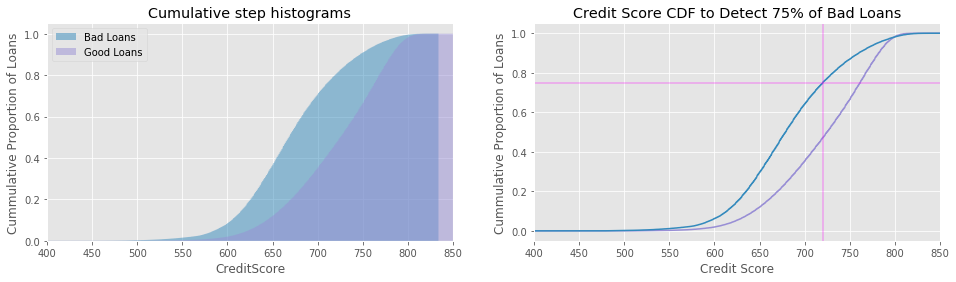

In [114]:
good_loans = data_filled[data_filled['IsBadLoan']==0]
bad_loans  = data_filled[data_filled['IsBadLoan']==1]

# for continuous variables
col = 'CreditScore'
nbins = 1000

fig, ax = plt.subplots(1,2,figsize=(16, 4))

n_bad, bins, patches = ax[0].hist( bad_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=True, label= 'Bad Loans', alpha = 0.5, color='C1')
n_good, bins, patches = ax[0].hist(good_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=True, label='Good Loans', alpha = 0.5, color='C2')

idx = (n_bad>0.75).argmax()

print(f'Credit Score > {int(bins[idx])}, Recall (TPR): {n_bad[idx]:.4f}, TNR: {n_good[idx]:.4f}')

ax[0].set_xlim(400, 850)
ax[0].set_xlabel(col)
ax[0].set_ylabel('Cummulative Proportion of Loans')
ax[0].legend(loc='upper left')
ax[0].set_title('Cumulative step histograms')

ax[1].plot(bins[:-1],n_good, color='C2')
ax[1].plot(bins[:-1],n_bad, color='C1')
ax[1].axhline(0.75, color='magenta', alpha=0.3)
ax[1].axvline( 720, color='magenta', alpha=0.3)
ax[1].set_title('Credit Score CDF to Detect 75% of Bad Loans')
ax[1].set_xlabel('Credit Score')
ax[1].set_ylabel('Cummulative Proportion of Loans')
ax[1].set_xlim(400,850)

plt.show();